# WUM homework 6 *~ validation*

Authors: Dawid Płudowski, Antoni Zajko

Reviewers: Grzegorz Zakrzewski, Tomasz Modzelewski

## Data preparation

In [1]:
# %load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, f1_score

from bioinfokit.visuz import cluster

sns.set(font_scale = 1.1)
sns.set_style("ticks", {'axes.grid' : True})
sns.set_palette("deep")

In [3]:
import os

os.chdir("../")

In [4]:
heart = pd.read_csv("./data/heart.csv")

In [5]:
heart.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


## EDA

In [6]:
heart.shape

(462, 10)

In [7]:
heart.dtypes

sbp            int64
tobacco      float64
ldl          float64
adiposity    float64
famhist       object
typea          int64
obesity      float64
alcohol      float64
age            int64
chd            int64
dtype: object

### Numerical variables

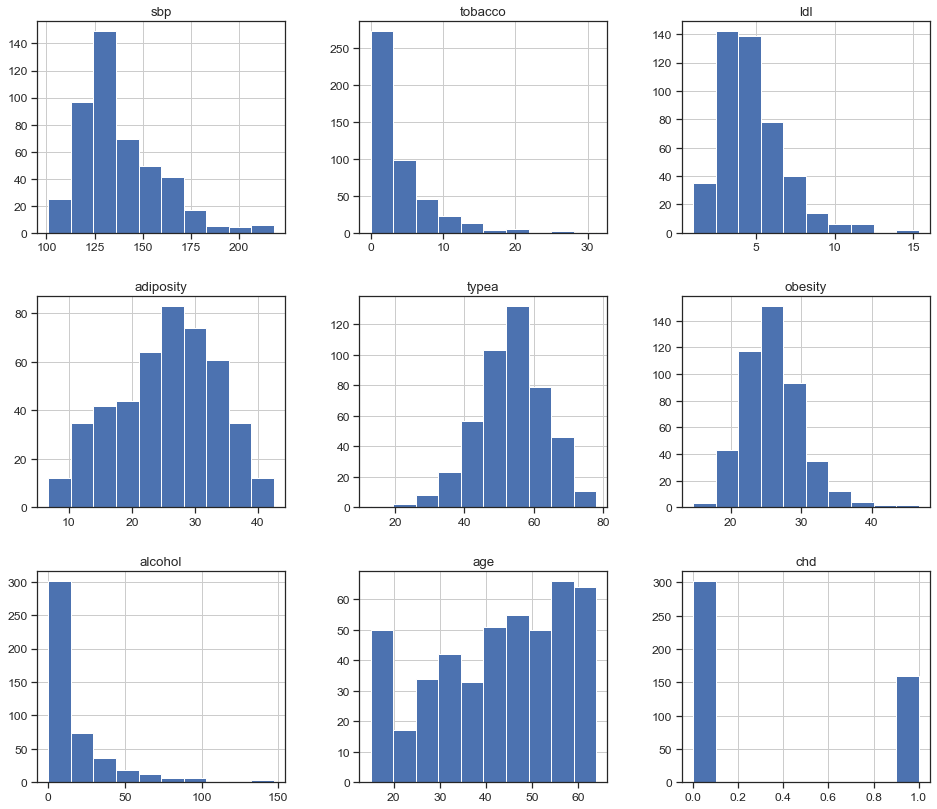

In [8]:
heart.hist(ax=plt.figure(figsize=(16, 14)).gca())
plt.show()

### Categorical variables

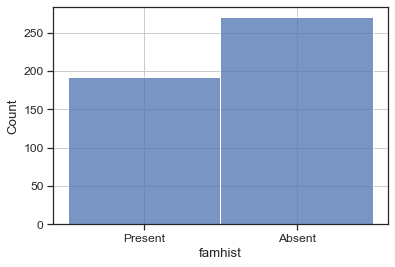

In [9]:
sns.histplot(x="famhist", data=heart)
plt.show()

## Preprocessing

In [10]:
numeric_columns = heart.columns
cat_columns = ["famhist"]

numeric_pipeline = Pipeline(
    [("power transformer", PowerTransformer(method="yeo-johnson", standardize=True))]
)

cat_pipeline = Pipeline([("ordinal encoding", OrdinalEncoder())])

full_pipeline = Pipeline(
    [("categoric pipeline", cat_pipeline), ("numeric pipeline", numeric_pipeline)]
)

In [11]:
heart_preproc = pd.DataFrame(full_pipeline.fit_transform(heart), columns=heart.columns)

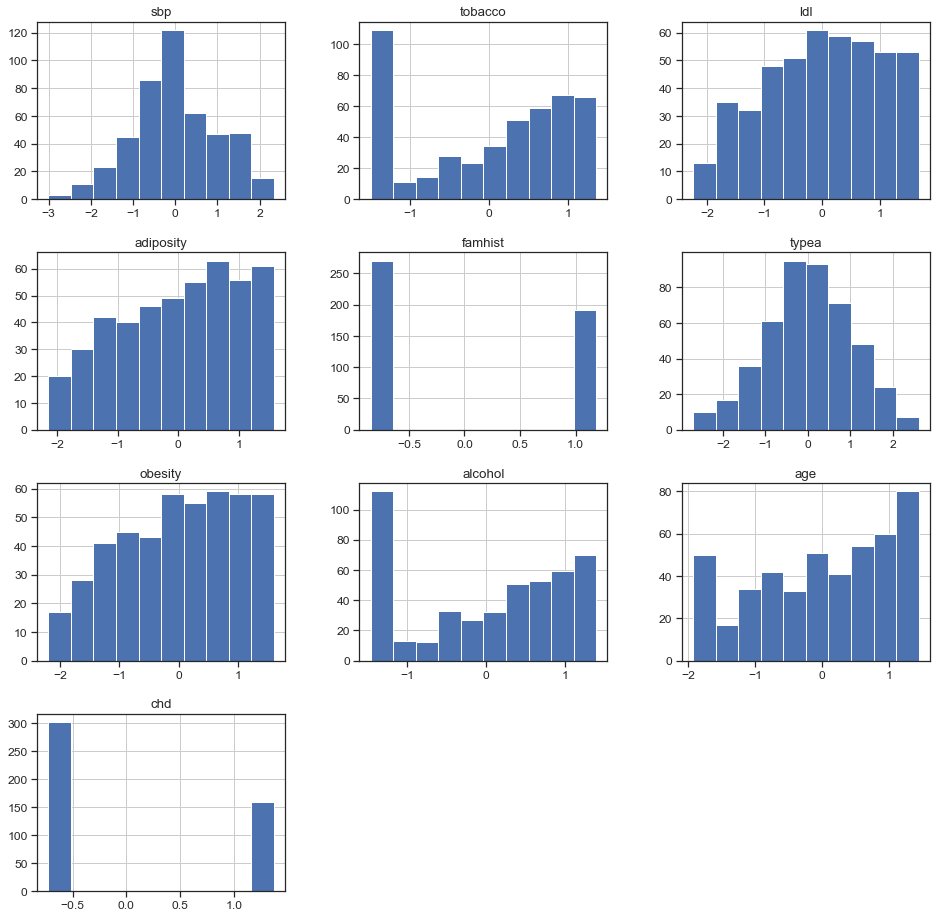

In [12]:
heart_preproc.hist(ax=plt.figure(figsize=(16, 16)).gca())
plt.show()

### Correlations

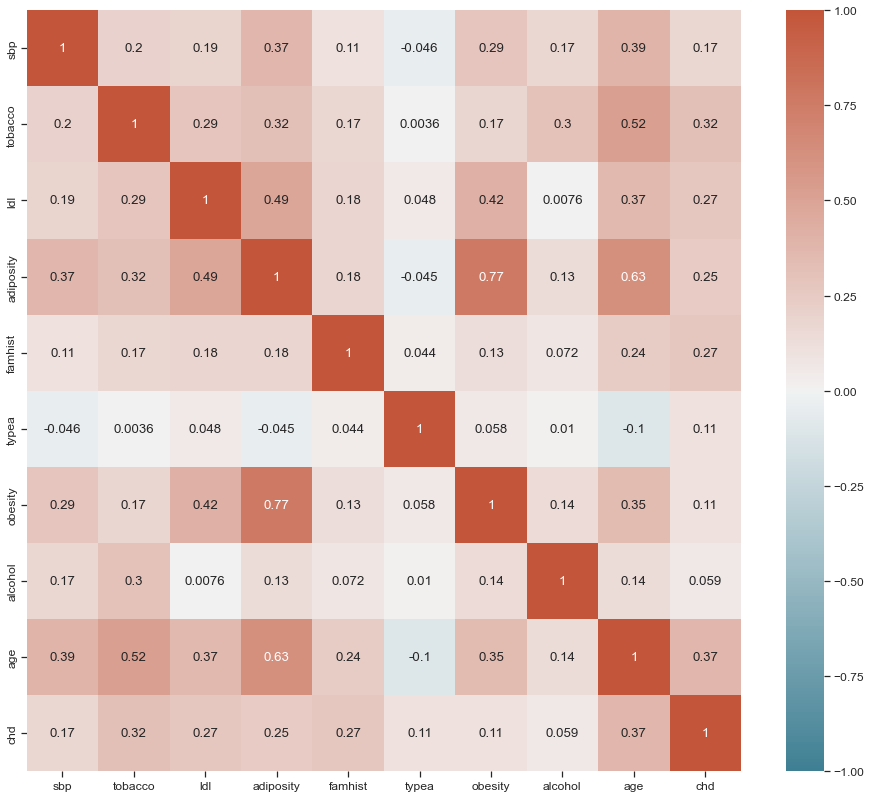

In [13]:
sns.heatmap(
    heart_preproc.corr(),
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    annot=True,
    ax=plt.figure(figsize=(16, 14)).gca(),
    vmin=-1, vmax=1, center=0 # ~validation
)
plt.show()

In [14]:
high_correlaitons = pd.DataFrame(columns=["col1", "col2", "corr"])
threshold = 0.5

correlations = heart_preproc.corr()
for i in range(correlations.shape[0]):
    for j in range(i + 1, correlations.shape[1]):
        if abs(correlations.iloc[i, j]) > threshold:
            vars = {
                "col1": correlations.columns[i],
                "col2": correlations.columns[j],
                "corr": correlations.iloc[i, j],
            }
            high_correlaitons = high_correlaitons.append(vars, ignore_index=True)

In [15]:
high_correlaitons

,col1,col2,corr
0,tobacco,age,0.524806
1,adiposity,obesity,0.772772
2,adiposity,age,0.629487


*~validation*

Task: show correlation using `Seaborn` library

Let's draw scatter plots for highly correlated features. 

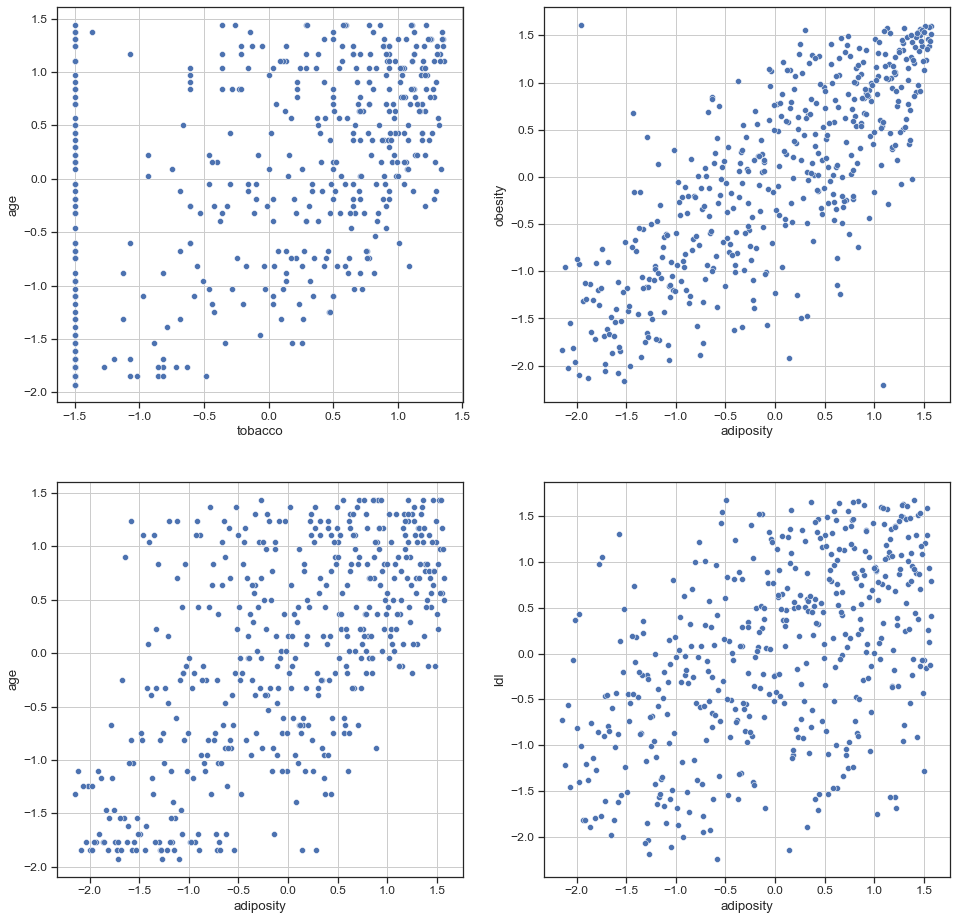

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

sns.scatterplot(data=heart_preproc, x='tobacco', y='age', ax=axs[0, 0])
sns.scatterplot(data=heart_preproc, x='adiposity', y='obesity', ax=axs[0, 1])
sns.scatterplot(data=heart_preproc, x='adiposity', y='age', ax=axs[1, 0])
sns.scatterplot(data=heart_preproc, x='adiposity', y='ldl', ax=axs[1, 1])

plt.show()

## PCA decomposition

In [17]:
%%capture

pca = PCA()
pca.fit(heart_preproc)

pca_names = ['PCA' + str(i) for i in range(1, pca.n_features_ + 1)]

### Biplot

In [18]:
# cluster.biplot(
#     cscore=PCA().fit_transform(heart_preproc),
#     loadings=pca.components_,
#     labels=heart.columns.values,
#     var1=round(pca.explained_variance_ratio_[0]*100, 2),
#     var2=round(pca.explained_variance_ratio_[1]*100, 2),
# )

![img](../resources/imgs/biplot_2d.png)

### Variance ratio plots

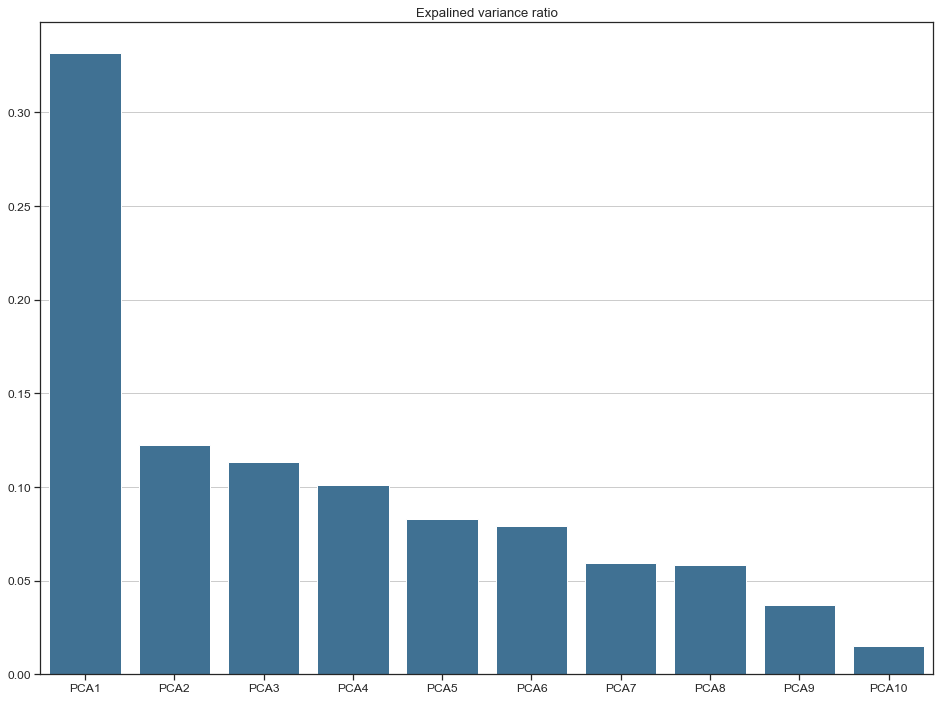

In [19]:
sns.barplot(
    x=pca_names,
    y=pca.explained_variance_ratio_,
    color="#3274a1",
    ax=plt.figure(figsize=(16, 12)).gca(),
).set_title("Expalined variance ratio")
plt.show()

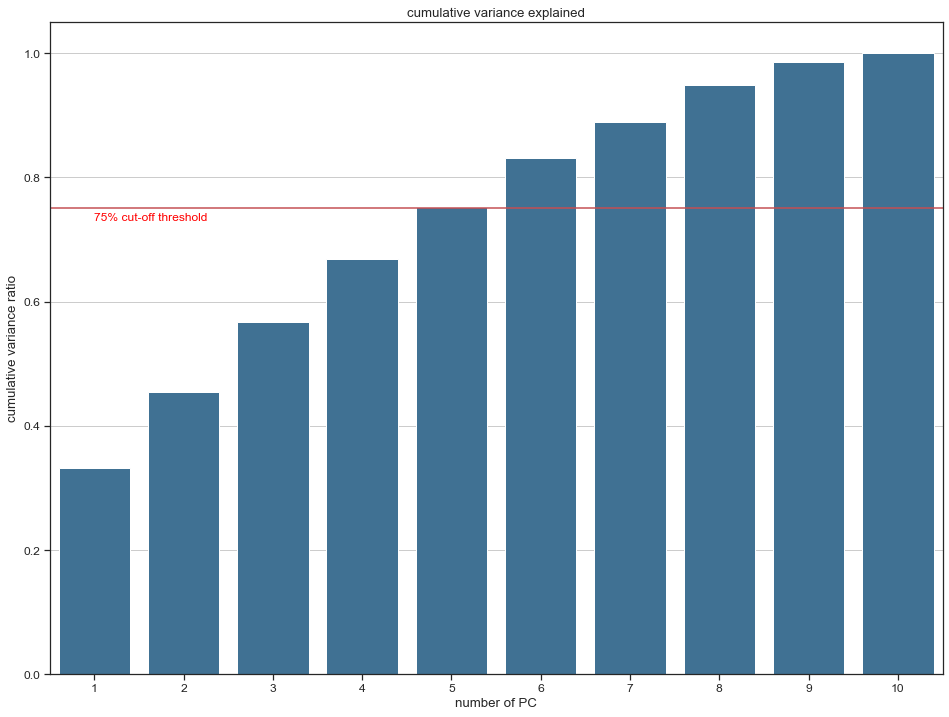

In [20]:
cum_df = pd.DataFrame(
    data={
        "number of PC": [i for i in range(1, pca.n_features_ + 1)],
        "cumulative variance ratio": np.cumsum(pca.explained_variance_ratio_),
        "variance ratio": pca.explained_variance_ratio_,
    }
)

sns.barplot(
    x="number of PC",
    y="cumulative variance ratio",
    data=cum_df,
    color="#3274a1",
    ax=plt.figure(figsize=(16, 12)).gca(),
).set_title("cumulative variance explained")

plt.axhline(y=0.75, color='r', linestyle='-')
plt.text(0, 0.73, '75% cut-off threshold', color = 'red', fontsize=12)

plt.show()

In [21]:
def show_min_variance(threshold):
    min_pc = np.min(
        cum_df.loc[cum_df["cumulative variance ratio"] > threshold]["number of PC"]
    )
    print(f"Minimal number of PC to explain {threshold*100:.2f}% of variance: {min_pc}")
    return min_pc


def show_min_change(threshold):
    min_add_pc = (
        np.min(cum_df.loc[cum_df["variance ratio"] < threshold]["number of PC"]) - 1
    )
    print(
        f"Last PC which explain more than {threshold*100:.2f}% of variance: {min_add_pc}"
    )
    return min_add_pc

In [22]:
show_min_variance(0.75);
show_min_variance(0.9);
show_min_change(0.1);
show_min_change(0.05);

Minimal number of PC to explain 75.00% of variance: 5
Minimal number of PC to explain 90.00% of variance: 8
Last PC which explain more than 10.00% of variance: 4
Last PC which explain more than 5.00% of variance: 8


## Conclusions

Based on plots and calculations, around 5 PC should be chosen, as they explain more than 75% of the variance, yet still reduce number of dimensions to 5 out of 10. If greater explanaiton level is required, one should consider reducing dimensions to 8, as it still explain more than 90% of the variance.

### *Kaiser's rule and elbow in scree plot ~ validation*

There are some other approaches used to determine the number of principal components to keep in a PCA.

> **Kaiser's (1960) eigenvalue-greater-than-one rule (K1 or Kaiser criterion)**
>
> Compute the eigenvalues for the correlation matrix and determine how many of these eigenvalues are greater than 1. This number is the number of factors to include in the model.

> **Scree plot**
>
> A scree plot always displays the eigenvalues in a downward curve, ordering the eigenvalues from largest to smallest. According to the scree test, the "elbow" of the graph where the eigenvalues seem to level off is found and factors or components to the left of this point should be retained as significant.

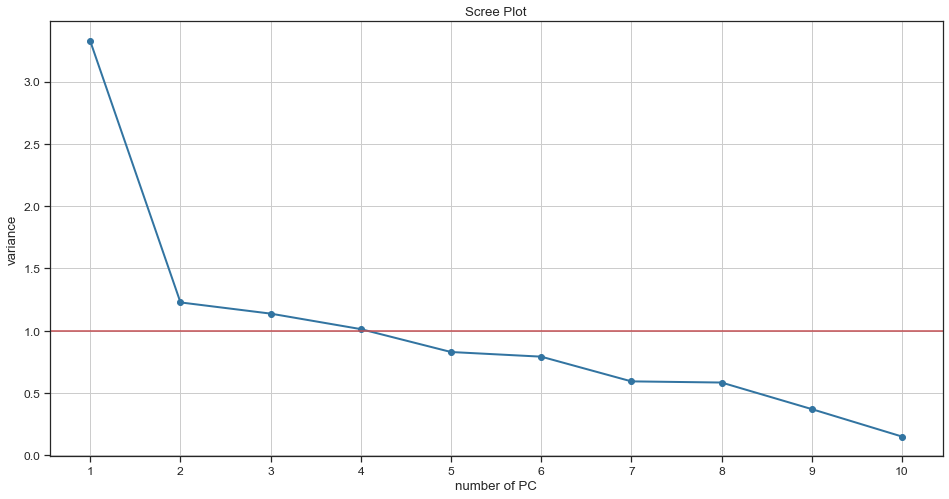

In [23]:
plt.figure(figsize=(16, 8))
x = range(1, pca.n_features_ + 1)
plt.plot(x, pca.explained_variance_, 'o-', linewidth=2, color='#3274a1')
plt.xlabel("number of PC")
plt.ylabel("variance")
plt.title("Scree Plot")
plt.xticks(x)
plt.axhline(y=1, color='r', linestyle='-')
plt.show()

According to these rules, it seems that only 2, 3 or 4 components should be kept.

### *Supervised learning algorithms ~ validation*

We can also train a model (e.g. Random Forest) which uses the reduced data to predict the values of each column of the non-reduced dataset. By comparing the scores of the model for different numbers of components, we can determine the number of components that should be kept.

In [24]:
def num_categorical(X):
    uniques = X.unique()
    return X.replace(uniques, np.arange(len(uniques))).astype('int')

def predictability(df, column, n_components, categorical=False):
    X = PCA(n_components=n_components, random_state=7778).fit_transform(df)
    y = num_categorical(df[column]) if categorical else df[column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8897)

    model, metric = (RandomForestClassifier, f1_score) if categorical else (RandomForestRegressor, mean_squared_error)
    rnd = model(n_estimators=1000)
    rnd.fit(X_train, y_train)

    return metric(y_test, rnd.predict(X_test))

In [25]:
numerical_columns = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
categorical_columns = ['famhist', 'chd']

In [26]:
#numerical_columns_scores = \
#    pd.DataFrame(
#        [ [ predictability(heart_preproc, column, n_components) for column in numerical_columns ] 
#            for n_components in range(1, len(heart_preproc.columns)+1) ],
#        columns = numerical_columns,
#        index = pd.RangeIndex(start = 1, stop = len(heart_preproc.columns)+1, name='n_components')
#    )
#categorical_columns_scores = \
#    pd.DataFrame(
#        [ [ predictability(heart_preproc, column, n_components, categorical=True) for column in categorical_columns ] 
#            for n_components in range(1, len(heart_preproc.columns)+1) ],
#        columns = categorical_columns,
#        index = pd.RangeIndex(start = 1, stop = len(heart_preproc.columns)+1, name='n_components')
#    )
#numerical_columns_scores.to_csv('resources/numerical_columns_scores.csv')
#categorical_columns_scores.to_csv('resources/categorical_columns_scores.csv')

In [27]:
numerical_columns_scores = pd.read_csv('resources/numerical_columns_scores.csv', index_col=0)
categorical_columns_scores = pd.read_csv('resources/categorical_columns_scores.csv', index_col=0)

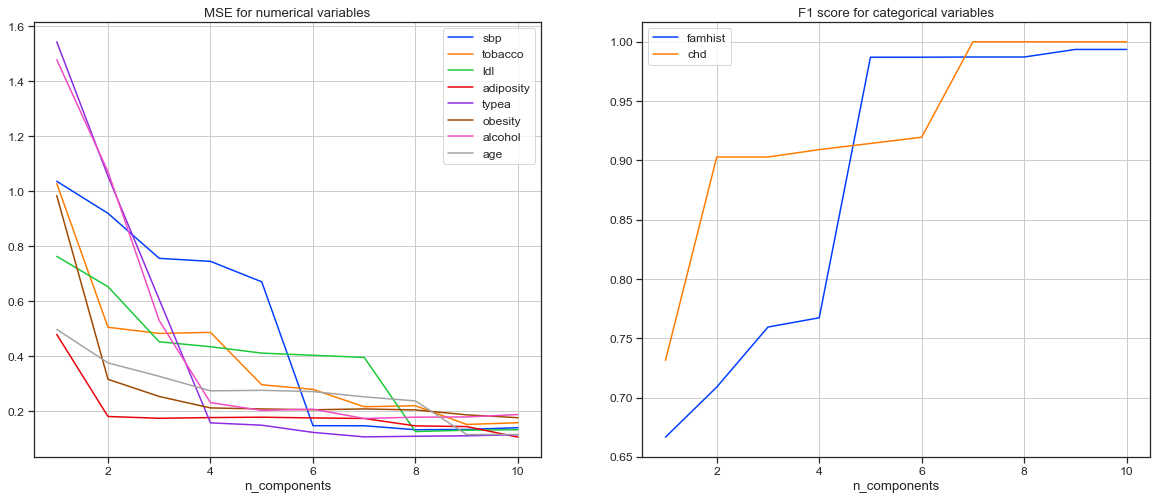

In [28]:
scores = (numerical_columns_scores, categorical_columns_scores)
titles = ('MSE for numerical variables', 'F1 score for categorical variables')

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

for i in range(len(scores)):
    sns.lineplot(data=scores[i], palette=sns.color_palette('bright')[:scores[i].shape[1]], dashes=['']*(scores[i].shape[1]), ax = ax[i])
    ax[i].set_title(titles[i])
plt.show()

According to the above, the efficient number of components is 5 or 6.